In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt

In [0]:
class CustomeGenerator(tf.keras.utils.Sequence):
  def __init__(self, x, y, batch_size):
    self.x = x
    self.y = y
    self.batch_size= batch_size
  def __len__(self):
    return np.ceil(len(self.x) / self.batch_size)
  
  def __getitem__(self, idx):
    batch_x = self.x[idx*self.batch_size : (idx+1)*self.batch_size]
    batch_y = self.y[idx*self.batch_size : (idx+1)*self.batch_size]

    return np.array([resize(imread(file_name), (200, 200)) for file_name in batch_x]), np.array(batch_y)

Generator methods

In [0]:
def __init__(self, list_IDs, Labels, batch_size, dim, n_channels, n_classes, shuffle=True):
  self.list_IDs = list_IDs
  self.Labels = Labels
  self.batch_size = batch_size
  self.dim = dim
  self.n_channels = n_channels
  self.n_classes = n_classes
  self.shuffle = shuffle
  self.on_epoch_end()

In [0]:
def on_epoch_end(self):
  self.indexes = np.arange(len(self.list_IDs))
  if self.shuffle:
    np.random.shuffle(self.indexes)
    

## Implement with mnist

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
class ImageGenerator(tf.keras.utils.Sequence):
  def __init__(self, x_data, y_data, batch_size, target_size, channel, shuffle, augment):
    self.x_data = x_data
    self.y_data = y_data
    self.batch_size = batch_size
    self.target_size = target_size
    self.channel = channel
    self.shuffle= shuffle
    self.augment = augment
    self.on_batch_end()

  
  def __len__(self):
    return int(np.ceil(len(self.x_data) / self.batch_size))

  def on_batch_end(self):
    self.indexes = np.arange(len(self.x_data))
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __getitem__(self, index):
    # get index 
    indexes= self.indexes[index * self.batch_size : (index+1) * self.batch_size]

    images = np.array([self.x_data[k] for k in indexes])
    labels = np.array([self.y_data[k] for k in indexes])
    

    if self.augment == True:
      images = self.augmentor(images)
    
    images = np.array([self.preprocess_input(img) for img in images])

    return images, labels


  def augmentor(self, images):
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    seq = iaa.Sequential(
				[
				# apply the following augmenters to most images
				iaa.Fliplr(0.5),  # horizontally flip 50% of all images    - left right 
				iaa.Flipud(0.2),  # vertically flip 20% of all images      - 
				sometimes(iaa.Affine(
					scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
					# scale images to 80-120% of their size, individually per axis
					translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
					# translate by -20 to +20 percent (per axis)
					rotate=(-10, 10),  # rotate by -45 to +45 degrees
					shear=(-5, 5),  # shear by -16 to +16 degrees
					order=[0, 1],
					# use nearest neighbour or bilinear interpolation (fast)
					cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
					mode=ia.ALL
					# use any of scikit-image's warping modes (see 2nd image from the top for examples)
				)),
				# execute 0 to 5 of the following (less important) augmenters per image
				# don't execute all of them, as that would often be way too strong
				iaa.SomeOf((0, 5),
				           [sometimes(iaa.Superpixels(p_replace=(0, 1.0),
						                                     n_segments=(20, 200))),
					           # convert images into their superpixel representation
					           iaa.OneOf([
							           iaa.GaussianBlur((0, 1.0)),
							           # blur images with a sigma between 0 and 3.0
							           iaa.AverageBlur(k=(3, 5)),
							           # blur image using local means with kernel sizes between 2 and 7
							           iaa.MedianBlur(k=(3, 5)),
							           # blur image using local medians with kernel sizes between 2 and 7
					           ]),
					           iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)),
					           # sharpen images
					           iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
					           # emboss images
					           # search either for all edges or for directed edges,
					           # blend the result with the original image using a blobby mask
					           iaa.SimplexNoiseAlpha(iaa.OneOf([
							           iaa.EdgeDetect(alpha=(0.5, 1.0)),
							           iaa.DirectedEdgeDetect(alpha=(0.5, 1.0),
							                                  direction=(0.0, 1.0)),
					           ])),
					           iaa.AdditiveGaussianNoise(loc=0,
					                                     scale=(0.0, 0.01 * 255),
					                                     per_channel=0.5),
					           # add gaussian noise to images
					           iaa.OneOf([
							           iaa.Dropout((0.01, 0.05), per_channel=0.5),
							           # randomly remove up to 10% of the pixels
							           iaa.CoarseDropout((0.01, 0.03),
							                             size_percent=(0.01, 0.02),
							                             per_channel=0.2),
					           ]),
					           iaa.Invert(0.01, per_channel=True),
					           # invert color channels
					           iaa.Add((-2, 2), per_channel=0.5),
					           # change brightness of images (by -10 to 10 of original value)
					           iaa.AddToHueAndSaturation((-1, 1)),
					           # change hue and saturation
					           # either change the brightness of the whole image (sometimes
					           # per channel) or change the brightness of subareas
					           iaa.OneOf([
							           iaa.Multiply((0.9, 1.1), per_channel=0.5),
							           iaa.FrequencyNoiseAlpha(
									           exponent=(-1, 0),
									           first=iaa.Multiply((0.9, 1.1),
									                              per_channel=True),
									           second=iaa.ContrastNormalization(
											           (0.9, 1.1))
							           )
					           ]),
					           sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5),
					                                               sigma=0.25)),
					           # move pixels locally around (with random strengths)
					           sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
					           # sometimes move parts of the image around
					           sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
				           ],
				           random_order=True
				           )
				], random_order=True)
    return seq.augment_image(images)

  def preprocess_input(self, images):
    if images.shape != 3:
      images = np.expand_dims(images, axis=2)
    return images / 255.

In [111]:
len(x_train[0].shape)

2

In [0]:
test_ = ImageGenerator(x_train, y_train, 25, (30,30), 1, shuffle=False, augment=False)

In [114]:
test_

In [115]:
next(iter(test_))

(array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
      

In [0]:
test_x, test_y = next(iter(test_))

In [117]:
test_x.shape

(25, 28, 28, 1)

In [118]:
test_y.shape

(25,)

In [0]:
test_ = ImageGenerator(x_train, y_train, 25, (30,30), 1, shuffle=False, augment=False)

In [0]:
def show_image(generator):
  images, labels = next(iter(generator))
  total_images = len(images)  # 25

  if images.shape[3] == 1:
    images = np.squeeze(images)

  for i in range(total_images):
    plt.subplot(5,5, i + 1)
    plt.axis('off')
    plt.title(labels[i])
    plt.imshow(images[i], cmap='gray')
    # plt.show()


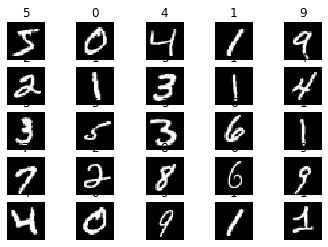

In [141]:
show_image(test_)

## Generator Check

In [0]:
test_ = ImageGenerator(x_train, y_train, 25, (30,30), 1, shuffle=True, augment=False)

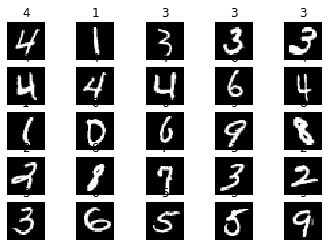

In [90]:
show_image(test_)

In [0]:
test_ = ImageGenerator(x_train, y_train, 25, (30,30), 1, shuffle=True, augment=True)

In [155]:
show_image(test_)

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/color.py:548: UserWarning: Received an image with shape (H, W, C) and C=28 in ChangeColorspace._augment_image(). Expected C to usually be 3 -- any other value will likely result in errors. (Note that this function is e.g. called during grayscale conversion and hue/saturation changes.)
  "changes.)" % (image.shape[2],)


error: ignored